This jupyter notebook is here to test properties of the training set (positive-defineteness, symmetry, etc)

In [7]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from os.path import exists
import scipy.linalg as linalg
import numpy as np
#import george # <- I love this name
from IPython.utils import io
import time, math, sys, os
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'

#sys.path.insert(1, '/Users/JoeyA/Research/CovNet')
sys.path.insert(1, "/home/u12/jadamo/CovNet")
import src as CovNet
import src.CovaPT as CovaPT

# sys.path.append('/home/joeadamo/Research/Software')
# from pk_tools import pk_tools

<Figure size 640x480 with 0 Axes>

In [2]:
train_nuisance = False
train_cholesky = True
#N = 111305
#N = 106299
#N = 111000
#training_dir = "/home/u12/jadamo/CovNet/Training-Set-HighZ-NGC/"
training_dir = "/xdisk/timeifler/jadamo/Training-Set-HighZ-NGC/"
#training_dir = "/xdisk/timeifler/jadamo/Training-Set-HighZ-NGC/"
#training_dir = "/Users/JoeyA/Research/COvNet/Training-Set-HighZ-NGC/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/u12/jadamo/CovaPT/Example-Data/"

In [3]:
def chi_squared(C, x):
    P = np.linalg.inv(C)
    return np.matmul(x.T, np.matmul(P, x))

In [4]:
def gaussian_covariance(params, i, offset):
    """
    Loads the model vector and gaussian covariance from file if it exists, otherwise calculates it
    """
    idx = i + offset
    data = np.load(training_dir+"CovG-"+f'{idx:05d}'+".npz")
    np.testing.assert_equal(params, data["params"], err_msg="parameters from file mismatch!")
    try:
        return data["model"], data["C"]
    except:
        Pk_galaxy = CovaPT.Pk_gg(params, pgg)
        model_vector = np.concatenate([Pk_galaxy[0], Pk_galaxy[2]])
        C_G = CovaPT.get_gaussian_covariance(params, pgg, Pk_galaxy)
        np.savez(training_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, model=model_vector, C_G=C_G, C_NG=data["C_NG"])
        return model_vector, C_G

In [5]:
t1 = time.time()
train_data = CovNet.MatrixDataset(training_dir, "training", 1., train_gaussian_only=False)
valid_data = CovNet.MatrixDataset(training_dir, "validation", 1., train_gaussian_only=False)
test_data = CovNet.MatrixDataset(training_dir, "testing", 1., train_gaussian_only=False)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 193.21 s


In [14]:
nans = []
non_symmetric = []
non_definete = []; avg_bad = []
cholesky_fail = 0
cholesky_fail_gaussian = 0

min_val, max_val = 1e10, -1e10

condition_numbers = np.zeros(len(train_data))

min_asym = 10000; max_asym = 0; avg_asym = 0.
# first test the base matrix
for i in tqdm(range(len(train_data))):
    C = train_data.get_full_matrix(i)
    
    # Test that I'm undoing pre-processing correctly
#     C_2 = valid_data[i][1].view(1,50,50)
#     C_2 = CovNet.symmetric_exp(C_2, 5.91572, 4.62748).view(50,50)
#     C_2 = torch.matmul(C_2, C_2.T).detach().numpy()
#     assert np.allclose(C, C_2)
    
    params = train_data[i][0].cpu().detach().numpy()
    
    if True in np.isnan(C) or True in np.isinf(C):
        nans.append(i)
        continue
    
    # test assymetry
    #symmetric_val = np.linalg.norm(C_asym, 2) / np.linalg.norm(C_sym, 2)
    try:
        np.testing.assert_allclose(C, C.T, err_msg="covariance must match transpose")
    except AssertionError:
        non_symmetric.append(i)
        #min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        #avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(C)
    if np.all(eigen >= 0.) == False:
        non_definete.append(i)
        avg_bad.append(len(eigen[(eigen < 0)]))
        
    # test that cholesky decomposition works
    try:
        L = np.linalg.cholesky(C)
        condition_numbers[i] = np.linalg.cond(C)
        
        min_val = min(min_val, np.amin(L))
        max_val = max(max_val, np.amax(L))
    except np.linalg.LinAlgError as err:
        cholesky_fail+=1

print("min - max values in L matrices: [{:0.3e}, {:0.3e}]".format(min_val, max_val)) 
print(len(nans), "Matrices had NaN or inf values!")
print(len(non_symmetric), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric)/len(valid_data)))
#print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete), "Matrices aren't positive definite, avg number of bad eigenvalues:", np.mean(avg_bad))
print(cholesky_fail, "Matrices fail to do cholesky decomposition")

100%|██████████| 526988/526988 [28:09<00:00, 311.84it/s]

min - max values in L matrices: [-7.756e+04, 8.386e+05]
0 Matrices had NaN or inf values!
0 (0.00%) Matrices are assymetric
0 Matrices aren't positive definite, avg number of bad eigenvalues: nan
0 Matrices fail to do cholesky decomposition



/home/u12/jadamo/virtual-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u12/jadamo/virtual-env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


543.2457 543.2457


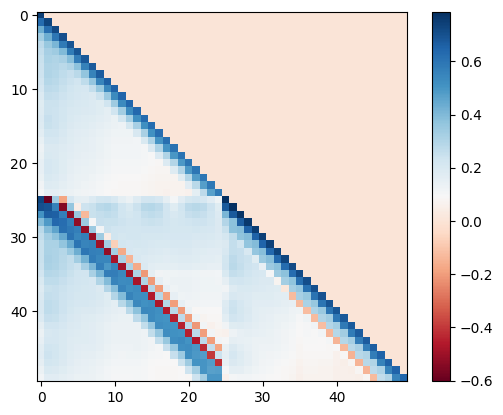

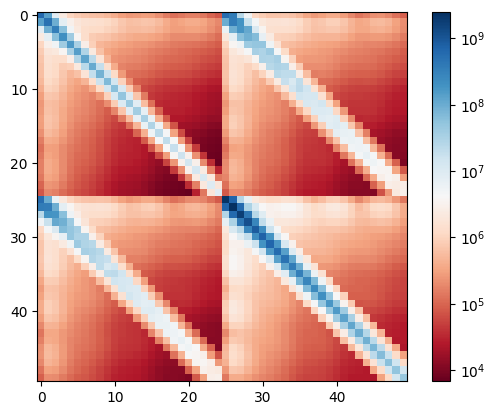

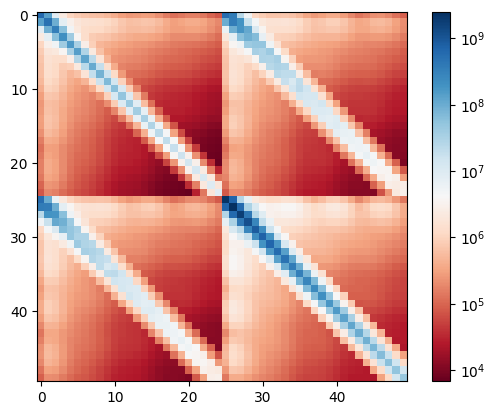

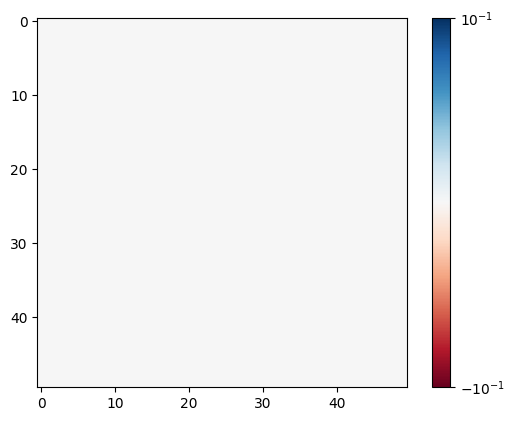

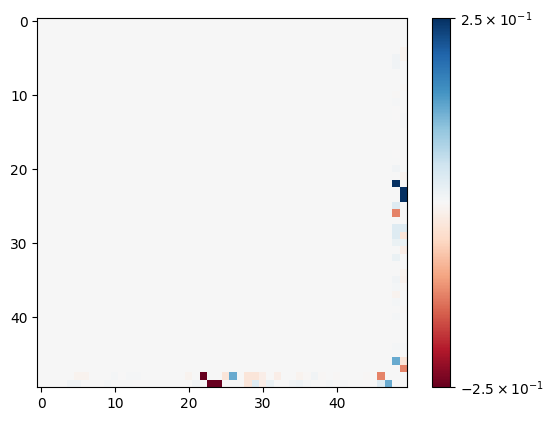

In [12]:
idx = np.random.randint(0, len(valid_data))

C = valid_data.get_full_matrix(idx)
C_raw = valid_data[idx][1]

plt.imshow(C_raw, cmap="RdBu")
plt.colorbar()

C_2 = CovNet.symmetric_exp(C_raw, 5.91572, 4.62748).view(50,50)
C_2 = torch.matmul(C_2, torch.t(C_2)).detach().numpy()

print(np.linalg.cond(C), np.linalg.cond(C_2))

plt.figure()
plt.imshow(C, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C), vmax=np.amax(C)))
plt.colorbar()

plt.figure()
plt.imshow(C_2, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_2), vmax=np.amax(C_2)))
plt.colorbar()

plt.figure()
plt.imshow(C - C.T, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C - C.T), vmax=np.amax(C - C.T)))
plt.colorbar()

plt.figure()
plt.imshow(C_2 - C_2.T, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_2 - C_2.T), vmax=np.amax(C_2 - C_2.T)))
plt.colorbar()

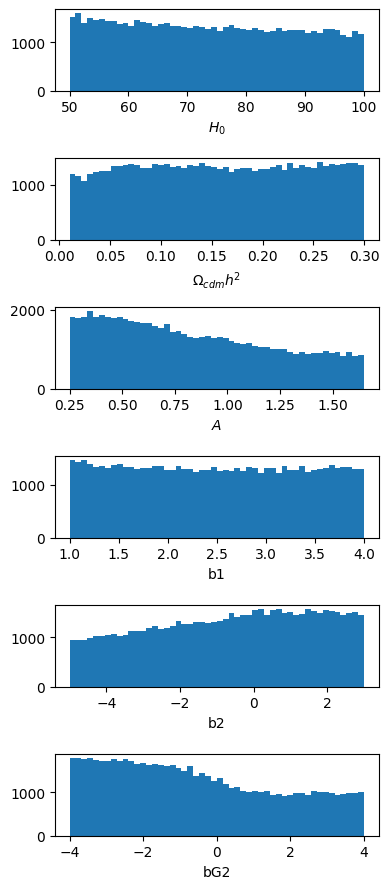

In [25]:
# check that the full set samples from the entire data range
params = test_data[:][0]
H0 = params[:,0].cpu().detach().numpy()
omch2 = params[:,1].cpu().detach().numpy()
As = params[:,2].cpu().detach().numpy()
b1 = params[:,3].cpu().detach().numpy()
b2 = params[:,4].cpu().detach().numpy()
bG2 = params[:,5].cpu().detach().numpy()

fig, ax = plt.subplots(6, figsize=(4, 9))
ax[0].hist(H0, bins=50);      ax[0].set_xlabel(r"$H_0$")
ax[1].hist(omch2, bins=50); ax[1].set_xlabel(r"$\Omega_{cdm} h^2$")
ax[2].hist(As, bins=50);   ax[2].set_xlabel(r"$A$")
ax[3].hist(b1, bins=50);      ax[3].set_xlabel(r"b1")
ax[4].hist(b2, bins=50);      ax[4].set_xlabel("b2")
ax[5].hist(bG2, bins=50);      ax[5].set_xlabel("bG2")
plt.tight_layout()

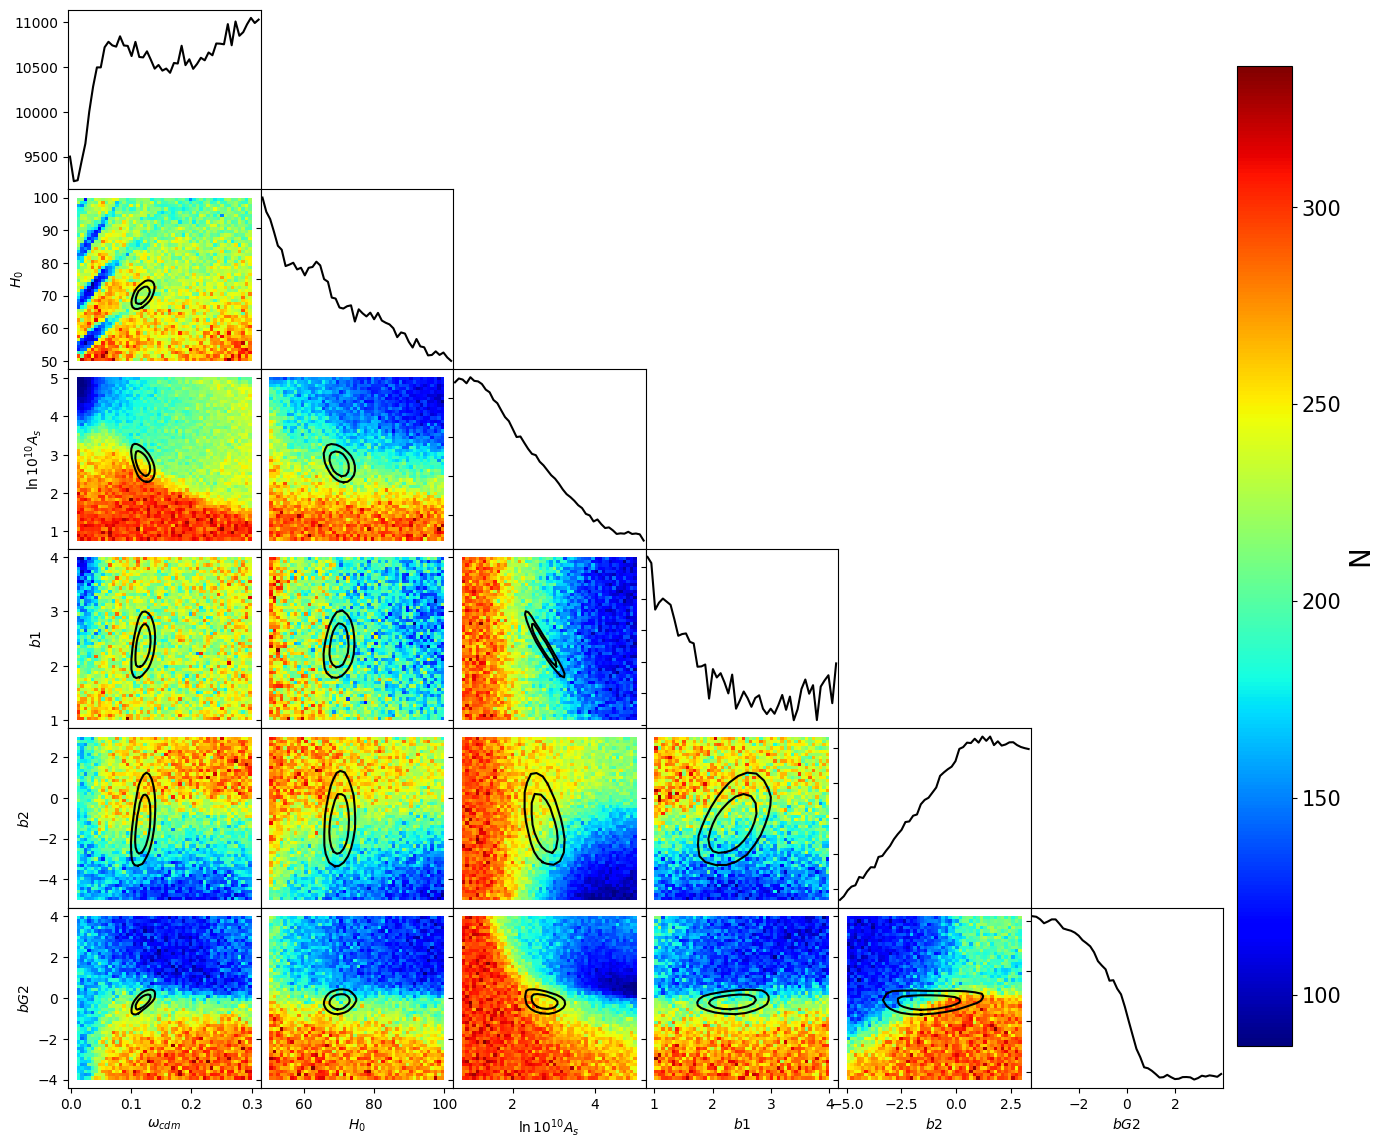

In [12]:
names = ['omch2', 'H0', "As", "b1", "b2", "bG2", "chi_squared"]
labels= [r'$\omega_{cdm}$', r"$H_0$", r"$\ln{10^{10} A_s}$", "$b1$", "$b2$", "$bG2$"]
#hypercube_params = np.loadtxt("/home/joeadamo/Research/CovNet/Data/Sample-params.txt", skiprows=1)
hypercube_params = np.loadtxt("/home/u12/jadamo/CovNet/Sample-params.txt", skiprows=1)
#params = hypercube_params
params = train_data[:][0].detach().numpy().copy()
params[:,2] *= 3.0447
params_temp = params[:,1].copy()
params[:,1] = params[:,0]
params[:,0] = params_temp

def extract_contours(name1, name2):
    file = "/home/u12/jadamo/CovNet/Plots/extracted-contours/"+name1+"-"+name2+".csv"
    contour1 = np.genfromtxt(file, skip_header=2, usecols=[0,1], delimiter=",", missing_values=",")
    contour2 = np.genfromtxt(file, skip_header=2, usecols=[2,3], delimiter=",", missing_values=",")
    return contour1, contour2

contour_bounds = np.array([[66, 70],
                           [0.09, 0.12],
                           [3, 3.6],
                           [1.6, 2.0],
                           [-4, -2.5],
                           [-0.4, 0.4]])

fig, axs = plt.subplots(6,6, figsize=(14,14))
#plt.suptitle("Training data set (N_total = 88,800)", fontsize=15)
for i in range(6):
    for j in range(6):
        if i < j:
            axs[i][j].axis("off")
            continue
        if i == j:
            hist, bin_edges = np.histogram(params[:,j], bins=50)
            width = bin_edges[1] - bin_edges[0]
            bins = np.linspace(bin_edges[0] + (width/2), bin_edges[-1] - (width/2), 50)
            axs[i][j].plot(bins, hist, c="black")
            axs[i][j].set_xlim(bin_edges[0], bin_edges[-1])
        else:
            #img = axs[i][j].scatter(params[:,j], params[:,i], c="black", s=0.1, alpha=0.5)
            img = axs[i][j].hist2d(params[:,j], params[:,i], bins=50, cmap="jet")
            
            try:
                contour1, contour2 = extract_contours(names[i], names[j])
                axs[i,j].plot(contour1[:,0], contour1[:,1], c="black")
                axs[i,j].plot(contour2[:,0], contour2[:,1], c="black")
            except:
                print("failed!")
            
            axs[i,j].set_xlim(np.amin(params[:,j]) - (np.amax(params[:,j]) - np.amin(params[:,j])) * 0.05, np.amax(params[:,j]) + (np.amax(params[:,j]) - np.amin(params[:,j])) * 0.05)
            axs[i,j].set_ylim(np.amin(params[:,i]) - (np.amax(params[:,i]) - np.amin(params[:,i])) * 0.05, np.amax(params[:,i]) + (np.amax(params[:,i]) - np.amin(params[:,i])) * 0.05)
            
        if i == 5: axs[i][j].set_xlabel(labels[j])
        if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
        if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
        elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
        elif j != 0 and i != 5:
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.96, 0.14, 0.039, 0.7])
cbar = fig.colorbar(img[3], cax=cbar_ax)
cbar.set_label("N" ,size=20)
cbar.ax.tick_params(labelsize=15) 
plt.subplots_adjust(wspace=0, hspace=0, right=0.95)

10583 141308362752.0


/home/u12/jadamo/virtual-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u12/jadamo/virtual-env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


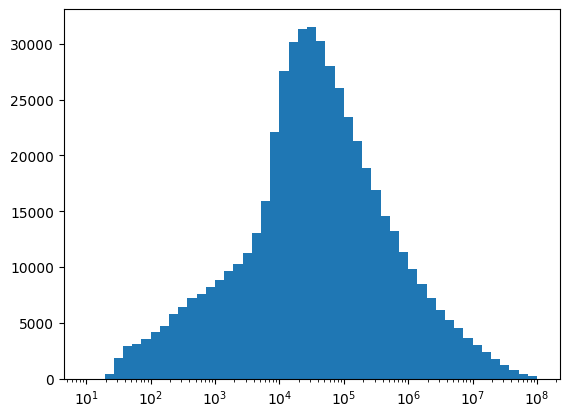

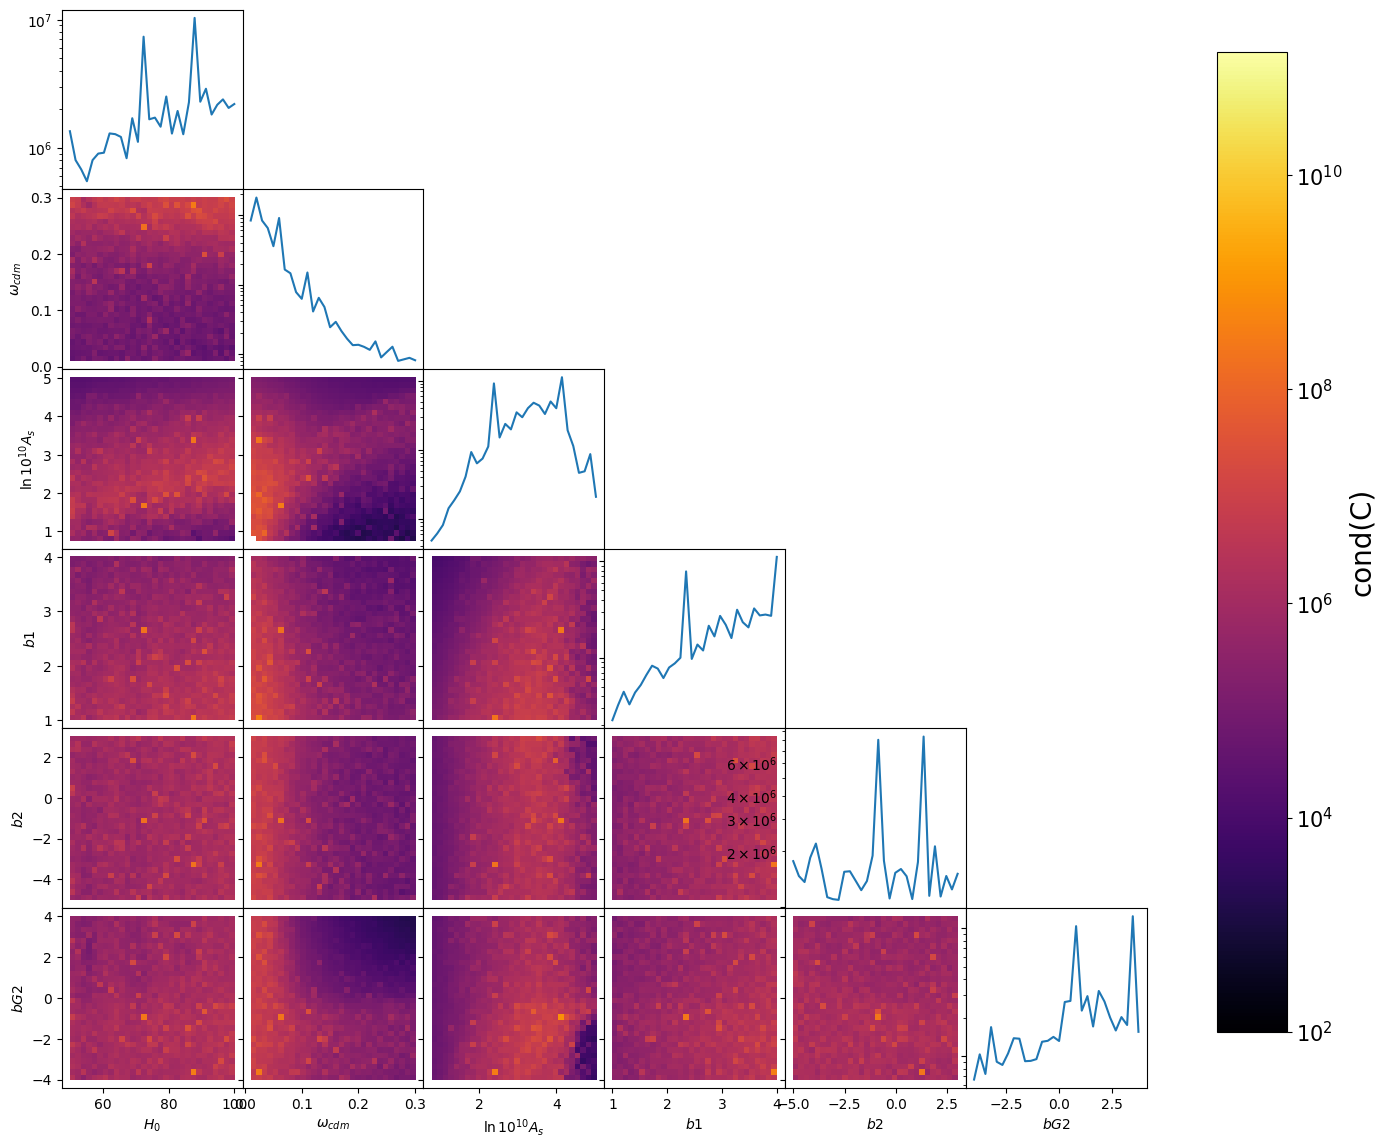

In [17]:
# visualize the condition numbers
params = train_data[:][0].detach().numpy().copy()
params[:,2] *= 3.0447
names = ['H0', 'omch2', "As", "b1", "b2", "bG2", "chi_squared"]
labels= [r"$H_0$", r'$\omega_{cdm}$', r"$\ln{10^{10} A_s}$", "$b1$", "$b2$", "$bG2$"]
cmap="inferno"
label=r"cond(C)"

params = params[(condition_numbers != 0)]
condition_nums = condition_numbers[(condition_numbers != 0)]

print(len(condition_nums[(condition_nums > 1e7)]), np.amax(condition_nums))

plt.figure()
plt.hist(condition_nums, bins=np.logspace(1, 8, 50))
plt.xscale("log")

def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

fig, axs = plt.subplots(6,6, figsize=(14,14))
#plt.suptitle("Training data set (N_total = 88,800)", fontsize=15)
for i in range(6):
    for j in range(6):
        if i < j:
            axs[i][j].axis("off")
            continue
        if i == j:
            x, y = make_diagonal(params[:,j], condition_nums, 30)
            axs[i][j].plot(x, y)
            axs[i][j].set_yscale("log")
        else:
            X, Y, Z = make_heatmap(params[:,j], params[:,i], condition_nums, 30)
            img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                  norm=colors.LogNorm(vmin=1e2, vmax=np.amax(condition_nums)))
            #else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
            axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
            axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
            
        if i == 5: axs[i][j].set_xlabel(labels[j])
        if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
        if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
        elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
        elif j != 0 and i != 5:
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label("cond(C)" ,size=20)
cbar.ax.tick_params(labelsize=15) 
plt.subplots_adjust(wspace=0, hspace=0)

## Plots to visualize distribution of the training set data wrt mcmc chains

In [6]:
# from Likelihood.ipynb
montepython_dir = "/xdisk/timeifler/jadamo/"
names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Omega_m", "H0", "sigma8"]
As_planck = 3.0447
def load_chains(prefix, burn_in, names):
    
    all_filenames = next(os.walk(montepython_dir+prefix), (None, None, []))[2]  # [] if no file
    chain_files = []
    for i in range(len(all_filenames)):
        if ".txt" in all_filenames[i]:
            if "._" in all_filenames[i][:2]:
                chain_files.append(all_filenames[i][2:])
            else:
                chain_files.append(all_filenames[i])

    chain_1 = np.genfromtxt(montepython_dir+prefix+chain_files[0], names=names)
    chain_2 = np.genfromtxt(montepython_dir+prefix+chain_files[1], names=names)
    chain_3 = np.genfromtxt(montepython_dir+prefix+chain_files[2], names=names)
    chain_4 = np.genfromtxt(montepython_dir+prefix+chain_files[3], names=names)

    # remove burn-in and "non-markovian" points from each chain
    chain_1 = chain_1[burn_in[0]:]
    chain_2 = chain_2[burn_in[1]:]
    chain_3 = chain_3[burn_in[2]:]
    chain_4 = chain_4[burn_in[3]:]

    # combine all chains into one big chain
    chain_combined = np.concatenate((chain_1, chain_2, chain_3, chain_4))
    chain_combined["As"] /= As_planck
    return chain_combined

In [16]:
#load_data = np.loadtxt("/home/u12/jadamo/CovNet/Inportance-Set/inportance-params.txt", skiprows=1)
load_data = load_chains("vary-no-determinant/", [97, 170, 76, 124], names_marg)
load_data_2 = load_chains("vary-determinant/", [190, 205, 195, 192], names_marg)

#hypercube_params = np.loadtxt("/home/joeadamo/Research/CovNet/Data/Sample-params.txt", skiprows=1)

num_in_range = 0
num_posdef = 0
num_posdef_2 = 0
params_posdef = np.array([0,0,0,0,0,0])
params_posdef_2 = np.array([0,0,0,0,0,0])

# min_data = np.amin(load_data, axis=0)
# max_data = np.amax(load_data, axis=0)
min_data = np.array([np.amin(load_data["H0"]),
                      np.amin(load_data["omch2"]),
                      np.amin(load_data["As"]),
                      np.amin(load_data["b1"]),
                      np.amin(load_data["b2"]),
                      np.amin(load_data["bG2"])])

max_data = np.array([np.amax(load_data["H0"]),
                      np.amax(load_data["omch2"]),
                      np.amax(load_data["As"]),
                      np.amax(load_data["b1"]),
                      np.amax(load_data["b2"]),
                      np.amax(load_data["bG2"])])

min_data_2 = np.array([np.amin(load_data_2["H0"]),
                      np.amin(load_data_2["omch2"]),
                      np.amin(load_data_2["As"]),
                      np.amin(load_data_2["b1"]),
                      np.amin(load_data_2["b2"]),
                      np.amin(load_data_2["bG2"])])

max_data_2 = np.array([np.amax(load_data_2["H0"]),
                      np.amax(load_data_2["omch2"]),
                      np.amax(load_data_2["As"]),
                      np.amax(load_data_2["b1"]),
                      np.amax(load_data_2["b2"]),
                      np.amax(load_data_2["bG2"])])

ratio = (max_data_2 - min_data_2) / (max_data - min_data)
V_ratio = 1.
for i in range(len(ratio)):
    V_ratio *= ratio[i]
print(V_ratio)
    
for i in tqdm(range(len(train_data))):
    params = train_data[i][0].detach().numpy()
    
    if np.all(params > min_data) and np.all(params < max_data):
        num_posdef += 1
        params_posdef = np.vstack((params_posdef, params))
    if np.all(params > min_data_2) and np.all(params < max_data_2):
        num_posdef_2 += 1
        params_posdef_2 = np.vstack((params_posdef_2, params))
        
# for i in tqdm(range(hypercube_params.shape[0])):
#     params = hypercube_params[i]
    
#     if np.all(params > np.amin(load_data, axis=0)) and np.all(params < np.amax(load_data, axis=0)):
#         num_in_range += 1
#         params_in_range = np.vstack((params_in_range, params))
        

#params_in_range = params_in_range[1:, :]
params_posdef = params_posdef[1:, :]

#print("{:0.0f} sets of parameters are in the inportance region".format(num_in_range))
print("{:0.0f} matrices in inportance region are positive definite".format(num_posdef))
print("{:0.0f} matrices in second chain are positive definite".format(num_posdef_2))

0.027411322463694928


100%|██████████| 526982/526982 [00:24<00:00, 21424.22it/s]

923 matrices in inportance region are positive definite
9 matrices in second chain are positive definite


(0.07984017, 0.132522)

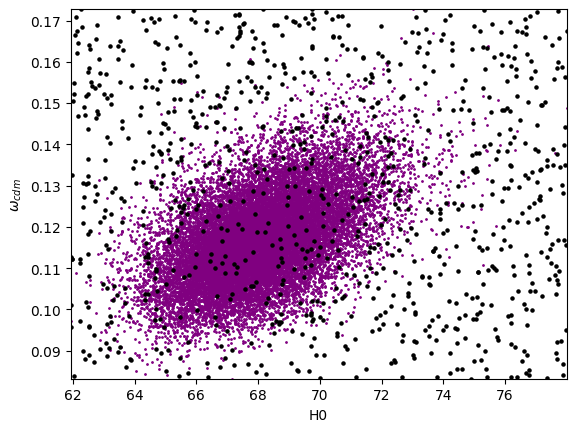

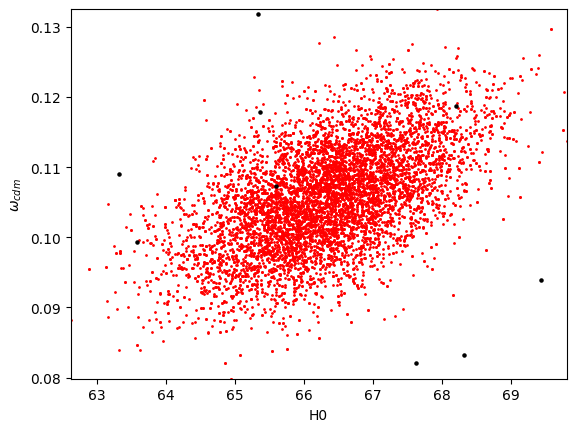

In [14]:
dim1 = 0; dim2 = 1
name1 = "H0"; name2 = "omch2"
plt.scatter(load_data[name1], load_data[name2], s=1, c="purple")
#plt.scatter(params_in_range[:,dim1], params_in_range[:,dim2], s=5, label="in training set")
plt.scatter(params_posdef[:,dim1], params_posdef[:,dim2], c="black", s=5, label="positive definite")
plt.xlabel("H0")
plt.ylabel(r"$\omega_{cdm}$")
plt.xlim(np.amin(load_data[name1]), np.amax(load_data[name1]))
plt.ylim(np.amin(load_data[name2]), np.amax(load_data[name2]))

plt.figure()
plt.scatter(load_data_2[name1], load_data_2[name2], s=1, c="red")
plt.scatter(params_posdef_2[:,dim1], params_posdef_2[:,dim2], c="black", s=5, label="positive definite")
plt.xlabel("H0")
plt.ylabel(r"$\omega_{cdm}$")
plt.xlim(np.amin(load_data_2[name1]), np.amax(load_data_2[name1]))
plt.ylim(np.amin(load_data_2[name2]), np.amax(load_data_2[name2]))

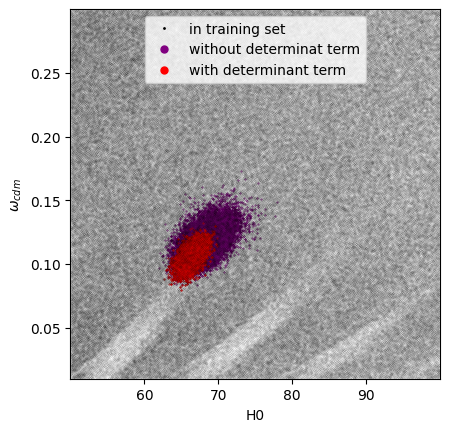

In [15]:
fix, ax = plt.subplots(1)
ax.scatter(load_data[name1], load_data[name2], s=0.1, c="purple")
ax.scatter(load_data_2[name1], load_data_2[name2], s=0.1, c="red")
ax.scatter(train_data[:][0][:,dim1], train_data[:][0][:,dim2], c="black", alpha=0.5, s=0.001)
ax.set_xlabel("H0")
ax.set_ylabel(r"$\omega_{cdm}$")
ax.set_xlim(torch.min(train_data[:][0][:,dim1]), torch.max(train_data[:][0][:,dim1]))
ax.set_ylim(torch.min(train_data[:][0][:,dim2]), torch.max(train_data[:][0][:,dim2]))
ratio = 1.0
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
legend_elements = [Line2D([0], [0], marker="o", color="black", ls="", label="in training set", markersize=1),
                   Line2D([0], [0], marker='o', color="purple", ls="", label='without determinat term', markersize=5),
                   Line2D([0], [0], marker="o", color="red", ls="", label="with determinant term", markersize=5)]
ax.legend(handles=legend_elements, loc="upper center")
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

The following cell computes the ocvariance matrix at the fiducial cosmology

In [9]:
# This cell computes the covariance matrix at the fiducial cosmology (TODO: move this to a better spot!)
t1 = time.time()
# params_fid = np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 5, -15, 100., 5e3])
# params_best = np.array([70.848,0.1120,0.7573, 2.8213,-0.2566, -0.0442, 12.0884, 4.54, 381.8, 984])
params_test = np.array([6.9383e+01, 1.18316e-01, 1.038e+00, 1.9094e+00, -2.956e+00, 2.06320e-01, 0, 0, 500, 0])
params_marg =  np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 0, 0, 500., 0])
Mat_Calc = CovaPT.Analytic_Covmat(0.61)
C_G, C_SSC, C_T0 = Mat_Calc.get_full_covariance(params_test)
C_fid = C_G + C_SSC + C_T0
#C_fid = C_G

t2 = time.time()
print("Matrix generated in {:0.2f} s".format(t2 - t1))

print(C_fid.shape)

print("cond(C) = {:0.3e}".format(np.linalg.cond(C_fid)))
try:
    L = np.linalg.cholesky(C_fid)
    print("Covariance matrix is positive-definite :)")
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")
    
# np.savez("../Data/Cov_Marg.npz", C_G=C_G, C_SSC=C_SSC, C_T0=C_T0)

/home/joeadamo//Research/CovNet/CovaPT.py:199: IntegrationWarning: The maximum number of subdivisions (60) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp = (quad(self.trispIntegrand, -1, 1,args=(k1,k2,Plin), limit=60)[0]/2. + expr)/self.i22**2


Matrix generated in 301.25 s
(50, 50)
cond(C) = 2.171e+06
Covariance matrix is NOT positive-definite!


Covariance matrix is positive-definite :)


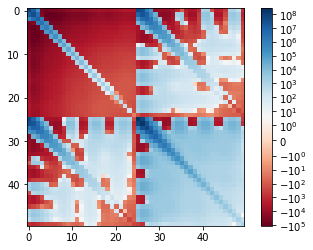

In [12]:
plt.figure()
plt.imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
plt.colorbar()

(96, 96)


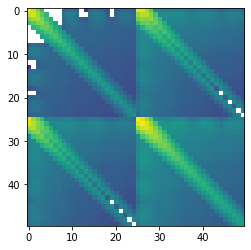

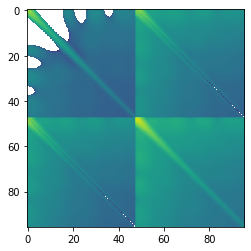

In [37]:
C_montepython = np.loadtxt("/home/joeadamo/Research/lss_montepython/data/ngc_z3/analytic_covmat.dat")
print(C_montepython.shape)

plt.imshow(C_fid, norm=colors.LogNorm(vmin=1e0, vmax=np.amax(C_fid)))

plt.figure()
plt.imshow(C_montepython, norm=colors.LogNorm(vmin=1e0, vmax=np.amax(C_fid)))

#### Replace gaussian matrix code

In [ ]:
Mat_Calc = CovaPT.Analytic_Covmat(0.61)
num_replace = 0
for i in tqdm(range(N)):
    data = np.load(training_dir+"CovA-"+f'{i:05d}'+".npz")
    
    C_G = data["C_G"]
    params = data["params"]
    C_G_new, Pk_galaxy_new = Mat_Calc.get_gaussian_covariance(np.concatenate([params, [0, 0, 500, 0]]), True)
    
    if np.allclose(C_G, C_G_new) == False:
        num_replace+=1
        C_SSC, C_T0 = data["C_SSC"], data["C_T0"]
        idx = f'{i:05d}'
        np.savez(training_dir+"CovA-"+idx+".npz", params=params, Pk=Pk_galaxy_new, C_G=C_G_new, C_SSC=C_SSC, C_T0 = C_T0)
print(num_replace, "total gaussian covariances recalculated")

In [14]:
train_data = None
full_data = np.load(training_dir+"CovA-training.npz")
params = full_data["params"]
C_G = full_data["C_G"]
C_NG = full_data["C_NG"]

# cut out 90% of the data
# this should let me run on my laptop
N = params.shape[0]
N_small = int(N * 0.1)

params = params[:N_small, :]
C_G = C_G[:N_small, :,:]
C_NG = C_NG[:N_small, :,:]

np.savez(training_dir+"CovA-training-small.npz", params=params, C_G=C_G, C_NG=C_NG)

### calculate pca of inverse matrix set

In [ ]:
inv_matrices = np.zeros((len(train_data), 50*50))

for i in tqdm(range(len(train_data))):
    C = train_data.get_full_matrix(i)
    P = np.linalg.inv(C).flatten()
    inv_matrices[i] = P

In [8]:
import pickle as pkl
pca = PCA(250)
components = pca.fit_transform(inv_matrices)
with open("/home/u12/jadamo/CovNet/pca-inv.pkl", "wb") as pickle_file:
    pkl.dump([pca], pickle_file)

### Data pre-processing code  
The following cells exist to test several different pre-processing methods for the covariance matrix

tensor([55.8036,  0.1022,  1.5248,  3.3097,  2.7118, -1.5698])
tensor(13312.)


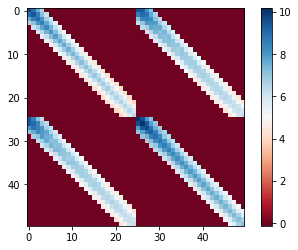

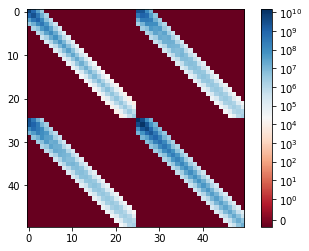

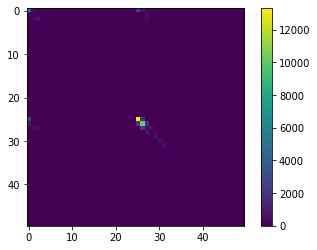

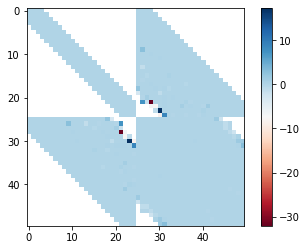

In [13]:
# test the logarithm function and make sure exp(log(C)) = C
idx = np.random.randint(0, N)
C = torch.from_numpy(all_data.get_full_matrix(idx))
C = C.to(torch.float32)
params = all_data[idx][0]
print(params)
C_log = CovNet.symmetric_log(C); C_1 = CovNet.symmetric_exp(C_log)
# C and C_1 should be equal, so C - C_1 should just be a matrix of all zeros
max_diff = torch.max(abs((C - C_1)))
print(max_diff)
# plt.imshow(C - C_1, cmap="RdBu")
# cbar = plt.colorbar()

plt.figure()
plt.imshow(C_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
m = plt.imshow(C_1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1.))
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C))
cbar = plt.colorbar()

plt.figure()
plt.imshow(100*(C_1 - C) / C, cmap="RdBu")
cbar = plt.colorbar()

In [20]:
C = all_data[idx][1].view(1,50,50)
C_0 = all_data[idx+1][1].view(1,50,50)
C = torch.cat((C, C_0), 0)
C_2 = all_data.get_full_matrix(idx)
C_3 = all_data.get_full_matrix(idx+1)

Det_predict = 2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(C), dim1=1, dim2=2)))
Det_actual = np.linalg.slogdet(C_2)[1] + np.linalg.slogdet(C_3)[1]
print(Det_predict, Det_actual)

tensor(1849.8190) 1849.819


tensor(2739.8652) tensor(3.4379) tensor(2739.8652)


<Figure size 432x288 with 0 Axes>

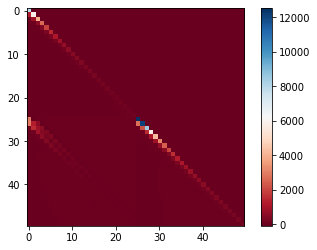

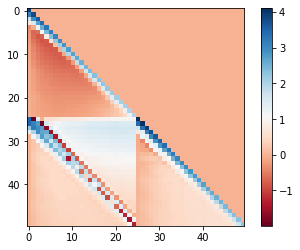

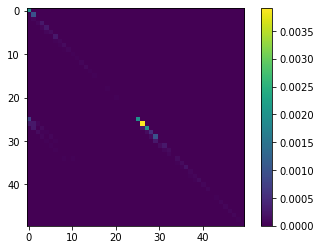

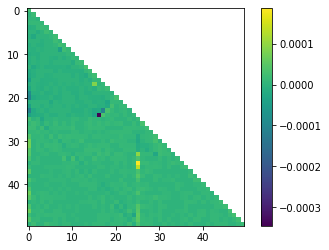

In [7]:
L = torch.linalg.cholesky(C)

#L = CovNet.rearange_to_half(L, 50).view(51, 25)
L_log = CovNet.symmetric_log(L)
L_2 = CovNet.symmetric_exp(L_log)

diff = abs(L - L_2)
idx_diff = torch.where(diff > 0)
print(L[26,25], L_log[26,25], L_2[26,25])

plt.figure()
C_sinh = np.arcsinh(C)
C_2 = np.sinh(C_sinh)
plt.figure()
plt.imshow(L, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(L_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(L_2 - L))
cbar = plt.colorbar()

plt.figure()
plt.imshow(100*abs(L_2 - L) / L)
cbar = plt.colorbar()

In [14]:
x = torch.linspace(-100, 100, 25, device=CovNet.try_gpu())
x_log = CovNet.symmetric_log(x)
x_1 = CovNet.symmetric_exp(x_log)
print(x)
print(x_log)
print(x_1)
print(x_1 - x)

tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00, -3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5.0000e+01,  5.8333e+01,
         6.6667e+01,  7.5000e+01,  8.3333e+01,  9.1667e+01,  1.0000e+02])
tensor([-2.0043e+00, -1.9669e+00, -1.9260e+00, -1.8808e+00, -1.8304e+00,
        -1.7733e+00, -1.7076e+00, -1.6301e+00, -1.5357e+00, -1.4150e+00,
        -1.2472e+00, -9.7004e-01, -1.6567e-06,  9.7004e-01,  1.2472e+00,
         1.4150e+00,  1.5357e+00,  1.6301e+00,  1.7076e+00,  1.7733e+00,
         1.8304e+00,  1.8808e+00,  1.9260e+00,  1.9669e+00,  2.0043e+00])
tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00, -3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5

In [15]:
# Convert data in .txt format to .npz format
# training_dir = "/home/joeadamo/Research/Data/Training-Set/"
# new_dir = "/home/joeadamo/Research/Data/Training-Set-New/"
# for idx in range(52500):
    
#     file = training_dir+"CovA-"+f'{idx:05d}'+".txt"
#     f = open(file)
#     header = f.readline()
#     header = f.readline()
#     f.close()
#     header = torch.from_numpy(np.fromstring(header[2:-1], sep=","))
#     params = torch.cat([header[0:4], header[5:]]).detach().numpy()
#     # load in matrix
#     C = np.loadtxt(file, skiprows=2)
#     np.savez(new_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, C=C)
    
#     test = np.load(new_dir+"CovA-"+f'{idx:05d}'+".npz")
#     params_l = test["params"]; C_l = test["C"]
#     assert np.array_equal(params_l, params) and np.array_equal(C, C_l)
# print("Done!")

In [1]:
# Test Cholesky decomposition
train_cholesky = True
idx = np.random.randint(0, N)
C = test_data[idx][1].view(1,100,100)
#C = symmetric_log(C)

if train_cholesky:
    C = torch.linalg.cholesky(C)
B = C.shape[0]
L1 = torch.tril(C)[:,:,:50]; L2 = torch.tril(C)[:,:,50:]
L1 = torch.cat((torch.zeros((B,1, 50), device=CovNet.try_gpu()), L1), 1)
L2 = torch.cat((torch.flip(L2, [1,2]), torch.zeros((B,1, 50), device=try_gpu())),1)
C_half = L1 + L2

C_full = torch.zeros((B, 100,100), device=CovNet.try_gpu())
C_full[:,:,:50] = C_full[:,:,:50] + C_half[:,1:,:]
C_full[:,:,50:] = C_full[:,:,50:] + torch.flip(C_half[:,:-1,:], [1,2])
L = torch.tril(C_full); U = torch.transpose(torch.tril(C_full, diagonal=-1),1,2)
if train_cholesky: # <- undo the cholesky decomposition
    C_full = torch.matmul(L, torch.transpose(L, 1, 2))
else:
    C_full = L + U
    
L = L.view(100,100); C = C.view(100,100); C_half = C_half.view(101,50); C_full = C_full.view(100,100)
chisq_true = chi_squared(C.cpu().detach().numpy(), x)
chisq_pred = chi_squared(C_full.cpu().detach().numpy(), x)
print(chisq_true, chisq_pred)

plt.imshow((symmetric_log(C).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_half).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_full).cpu()), cmap="RdBu")
cbar = plt.colorbar()
# try training the quadrants independently

plt.figure()
plt.imshow(abs(torch.matmul(C, torch.t(C)) - C_full).cpu())
cbar = plt.colorbar()

NameError: name 'np' is not defined

In [ ]:
# test code to convert to / from correlation matrix
idx = np.random.randint(0, N)
print("idx = ", idx)
C = test_data[idx][1].view(1, 100, 100)
D = torch.sqrt(torch.diagonal(C,0,1,2))
D = torch.diag_embed(D)
Corr = torch.matmul(torch.linalg.inv(D), torch.matmul(C, torch.linalg.inv(D)))
Corr = Corr + (CovNet.symmetric_log(D) - torch.eye(100))

plt.figure()
plt.imshow(CovNet.symmetric_log(C).view(100,100), cmap="RdBu")
plt.colorbar()

plt.figure()
plt.imshow(Corr.view(100,100).cpu())
cbar = plt.colorbar()

D_1 = torch.diag_embed(torch.diagonal(Corr,0,1,2))
Corr = Corr - (D_1) + torch.eye(100)
D_1 = CovNet.symmetric_exp(D_1)
C_1 = torch.matmul(D_1, torch.matmul(Corr, D_1))

plt.figure()
plt.imshow(CovNet.symmetric_log(C_1).view(100,100).cpu(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C).view(100,100).cpu())
cbar = plt.colorbar()

In [ ]:
# test code for splitting up matrix into quadrands
idx = np.random.randint(0, int(N*0.1))
print("idx = ", idx)
C = test_data[idx][1].view(1, 100, 100)
quad1 = C[:,:50,:50]
quad2 = C[:,50:,50:]
quad3 = C[:,:50,50:]

C = C.view(100,100); quad1 = quad1.view(50,50); quad2 = quad2.view(50,50); quad3 = quad3.view(50,50)
plt.imshow(C.cpu().detach().numpy(), cmap="RdBu")
plt.colorbar()

print(quad1.shape, quad2.shape, quad3.shape)
plt.figure()
plt.imshow(quad1.cpu().detach().numpy(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(quad2.cpu().detach().numpy(), cmap="RdBu")

plt.figure()
plt.imshow(quad3.cpu().detach().numpy(), cmap="RdBu")

plt.figure()
plt.imshow(abs(quad3 - torch.t(quad3)).cpu().detach().numpy())
cbar = plt.colorbar()

In [ ]:
# If there are any matrices with NaN's or inf's, check them out
print(nans)
if len(nans) != 0:
    params = test_data[nans][0]
    C = test_data[nans][1].view(100,100).detach().numpy()
    print(np.where(np.isnan(C)==True))

    data_bad = np.load(training_dir+"CovNG-30528.npz")
    print(data_bad["C"][98,98])

    print(params)
    plt.imshow(C, cmap="RdBu")
    plt.colorbar()

## PCA Code

In [100]:
# find the PCA reconstruction error for a given number of PCs

min_v, max_v = test_data.do_PCA(250, training_dir)

def PCA_error(data, num_pc, noise_amount=1.):
    if os.path.exists("./pca.pkl"):
        os.remove("./pca.pkl")
    #min_v, max_v = data.do_PCA(num_pc)
    variance = np.cumsum(data.pca.explained_variance_ratio_)[-1]
    weight = torch.flip(torch.arange(0, 500, 2), (0,)) / 500
    
    loss = 0
    error = torch.zeros(len(data))
    for i in tqdm(range(len(data))):
        if noise_amount != 1.:
            #noise_vector = ((torch.rand(num_pc) - 0.5) * noise_amount * weight).detach()
            #comp = data.components[i] + noise_vector
            #error[i] = torch.mean(abs(noise_vector / data.components[i])).detach()
            comp = torch.clone(data.components[i]).detach()
            noise_value = (torch.rand(1) - 0.5) * noise_amount
            comp[0] = comp[0] + noise_value
            error[i] = abs(noise_value / data.components[i][0])
        else:
            comp = data.components[i]
        C = CovNet.reverse_pca(comp, data.pca, min_v, max_v).view(1, 51, 25)
        C = CovNet.rearange_to_full(C, 50, True).view(50,50)
        C2 = CovNet.reverse_pca(data.components[i], data.pca, min_v, max_v).view(1, 51, 25)
        C2 = CovNet.rearange_to_full(C2, 50, True).view(50,50)
        loss += F.l1_loss(C, C2, reduction="sum").item()
        
    idx = torch.where(torch.isinf(error) == False)
    return loss / len(data), variance, torch.mean(error[idx])

def PCA_net_error(data, num_pc, net):
#     if os.path.exists("./pca.pkl"):
#         os.remove("./pca.pkl")
    #min_v, max_v = data.do_PCA(num_pc)
    variance = np.cumsum(data.pca.explained_variance_ratio_)[-1]
    
    loss_full = 0
    loss_sub = 0
    error = torch.zeros((len(data), 250))
    for i in tqdm(range(len(data))):
        #noise_vector = ((torch.rand(num_pc) - 0.5) * noise_amount * weight).detach()
        #comp = data.components[i] + noise_vector
        #error[i] = torch.mean(abs(noise_vector / data.components[i])).detach()
        comp = torch.clone(data.components[i]).detach()
        comp_net = net(data[i][0].view(1,6)).view(250)
        comp[0] = comp_net[0]
        error[i] = (comp_net - data.components[i]) / data.components[i]

        C = CovNet.reverse_pca(comp, data.pca, min_v, max_v).view(1, 51, 25)
        C = CovNet.rearange_to_full(C, 50, True).view(50,50)
        
        C2 = CovNet.reverse_pca(data.components[i], data.pca, min_v, max_v).view(1, 51, 25)
        C2 = CovNet.rearange_to_full(C2, 50, True).view(50,50)
        loss_full += F.l1_loss(C, data[i][1], reduction="sum").item()
        loss_sub += F.l1_loss(C, C2, reduction="sum").item()
        
    #idx = torch.where(torch.isinf(error) == False)
    return loss_full / len(data), loss_sub / len(data), error

def get_PCA(data, num_pc):
    if os.path.exists("./pca.pkl"):
        os.remove("./pca.pkl")
    min_v, max_v = data.do_PCA(num_pc)
    return data.pca

In [61]:
weight = torch.flip(torch.arange(0, 500, 2), (0,)) / 500
noise_vector = (torch.rand(250) - 0.5) * 0.01 * weight
components = test_data.components[38546]

# print(torch.mean(abs(noise_vector / components)))

# print(torch.sum(abs(noise_vector)))
# plt.plot(components, linewidth=2)
# plt.plot(components + noise_vector)

loss = torch.zeros(15)
error = torch.zeros(15)
noise_amount = torch.logspace(-4, -1, 15)
print(noise_amount)
for i in range(15):
    loss[i], variance, error[i] = PCA_error(test_data, 250, noise_amount[i])
    # print(loss, error)

# pc_numbers = np.linspace(100, 600, 40)
# pc_loss = np.zeros(40)
# variance = np.zeros(40)
# for i in range(len(pc_numbers)):
#     pc_loss[i], variance[i] = PCA_error(test_data, int(pc_numbers[i]))

# print(pc_loss)

tensor([1.0000e-04, 1.6379e-04, 2.6827e-04, 4.3940e-04, 7.1969e-04, 1.1788e-03,
        1.9307e-03, 3.1623e-03, 5.1795e-03, 8.4834e-03, 1.3895e-02, 2.2758e-02,
        3.7276e-02, 6.1054e-02, 1.0000e-01])


100%|██████████| 65872/65872 [01:24<00:00, 777.70it/s]


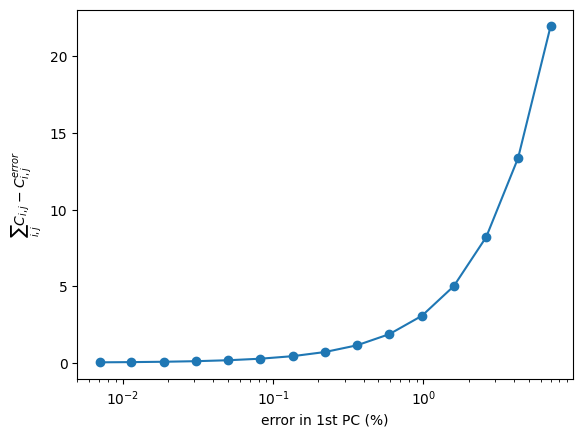

In [62]:
# plt.plot(error * 100, loss, marker="o")
# plt.scatter(0.0042 * 100, 21.868, c="black")
# plt.xlabel("average error per PC (%)")
# plt.ylabel("Average L1 loss")
# plt.xscale("log")

plt.plot(error*100, loss, marker="o")
plt.xlabel("error in 1st PC (%)")
plt.ylabel(r"$\sum_{i,j} C_{i,j} - C_{i,j}^{error}$")
plt.xscale("log")

# fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[2,1])
# axs[0].plot(pc_numbers, pc_loss)
# axs[0].axhline(5.77, ls="--", c="black", label="MLP netowrk loss")
# axs[1].plot(pc_numbers, variance)
# axs[1].set_xlabel("number of PCs")
# axs[0].set_ylabel("Average L1 Loss")
# axs[1].set_ylabel("Explained Variance")
# axs[0].set_xlim(100, 600)
# axs[0].legend()
# plt.subplots_adjust(hspace=0)

tensor(0.0013, dtype=torch.float64)


100%|██████████| 65872/65872 [03:53<00:00, 282.00it/s]


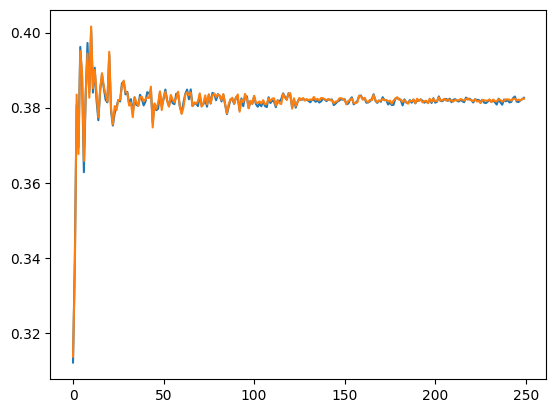

In [101]:
net_dir = "/home/u12/jadamo/CovNet/emulators/ngc_z3/MLP-PCA/"
net = CovNet.Network_Emulator("MLP-PCA").to(torch.device("cpu"));       net.eval()
net.load_state_dict(torch.load(net_dir+'network.params', map_location=torch.device('cpu')))

idx = np.random.randint(len(test_data))
params = test_data[idx][0].view(1, 6)
components = test_data.components[idx]
components_net = net(params).view(250).detach()

plt.plot(components)
plt.plot(components_net)

print(torch.mean(abs((components_net - components) / components)))
loss_full, loss_mean, error = PCA_net_error(test_data, 250, net)

total loss = 8.642, loss from just 1st PC error = 5.241, average error on 1st PC = 1.620%


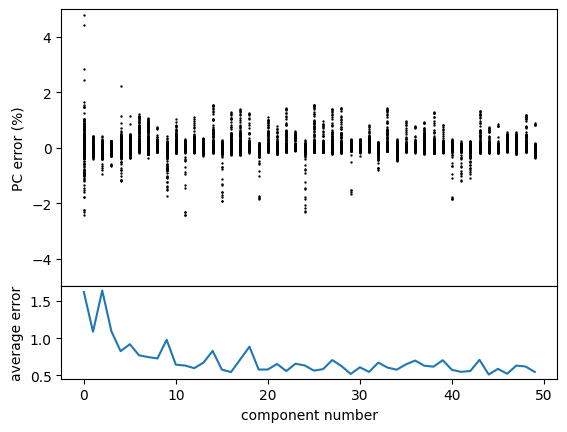

In [107]:
error_1 = 100*torch.mean(abs(error[:,0]))

print("total loss = {:0.3f}, loss from just 1st PC error = {:0.3f}, average error on 1st PC = {:0.3f}%".format(
    loss_full, loss_mean, error_1))

fix, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
for i in range(50):
    axs[0].scatter(np.ones(len(test_data))*i, error[:,i].detach(), c="black", s=0.5)
mean_error = 100*torch.mean(abs(error), dim=0).detach()
axs[1].plot(range(50), mean_error[:50])
    
axs[0].set_ylim(-5, 5)
axs[1].set_xlabel("component number")
axs[0].set_ylabel("PC error (%)")
axs[1].set_ylabel("average error")
plt.subplots_adjust(hspace=0)

Noise of 0.0003 0.0978% applied
Network off by 0.0039 (1.2502%)
Loss from PC error is 3.400291919708252


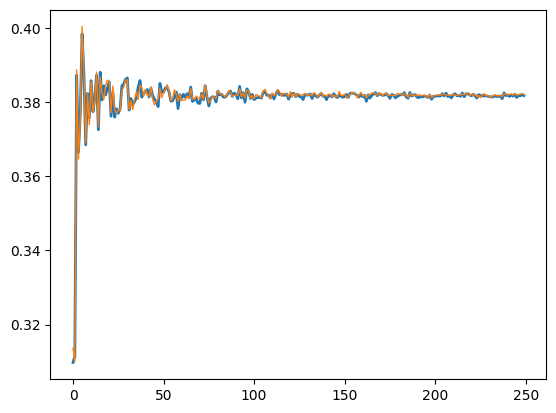

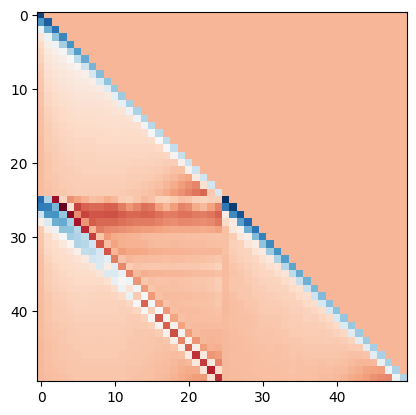

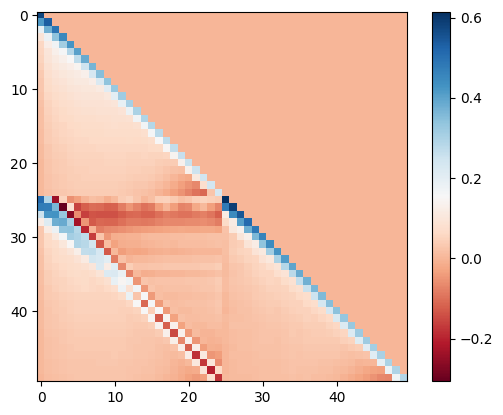

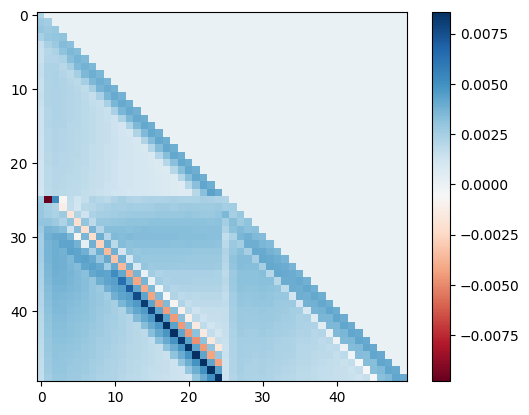

In [83]:
idx = np.random.randint(len(test_data))

noise_value = (torch.rand(1) - 0.5) * 0.02

components = test_data.components[idx]
noisy_comp = torch.clone(components).detach()
components_net = net(test_data[idx][0].view(1,6)).view(250).detach()
noisy_comp[0] = components_net[0]

plt.plot(components, linewidth=2)
#plt.plot(noisy_comp, linewidth=3)
plt.plot(components_net, linewidth=1)

C = CovNet.reverse_pca(noisy_comp, test_data.pca, min_v, max_v).view(1, 51, 25)
C = CovNet.rearange_to_full(C, 50, True).view(50,50)

C2 = CovNet.reverse_pca(components, test_data.pca, min_v, max_v).view(1, 51, 25)
C2 = CovNet.rearange_to_full(C2, 50, True).view(50,50)
L = F.l1_loss(C, C2, reduction="sum").item()
print("Noise of {:0.4f} {:0.4f}% applied".format(noise_value.item(), 100*abs(noise_value / components[0]).item()))
print("Network off by {:0.4f} ({:0.4f}%)".format(components_net[0] - components[0], 100*(components_net[0] - components[0]) / components[0]))
print("Loss from PC error is", L)

plt.figure()
plt.imshow(test_data[idx][1], cmap="RdBu")

plt.figure()
plt.imshow(C2, cmap="RdBu")
plt.colorbar()

plt.figure()
plt.imshow(C - C2, cmap="RdBu")
plt.colorbar()

In [80]:
def reconstruct_matrix(matrix, pc_number, data):
    pca = get_PCA(data, pc_number)
    matrix = torch.from_numpy(np.linalg.cholesky(matrix)).to(torch.float32).view(1,50,50)
    matrix = CovNet.symmetric_log(matrix, data.norm_pos, data.norm_neg)
    matrix = CovNet.rearange_to_half(matrix, 50).view(1, 51*25)
    pc = pca.transform(matrix)
    
    matrix_2 = torch.from_numpy(pca.inverse_transform(pc))
    print(F.l1_loss(matrix, matrix_2, reduction="sum"))
    matrix_2 = CovNet.rearange_to_full(matrix_2.view(1, 51, 25), 50, True)
    matrix_2 = CovNet.symmetric_exp(matrix_2, data.norm_pos, data.norm_neg)
    matrix_2 = matrix_2.view(50,50).detach().numpy()
    matrix_2 = np.matmul(matrix_2, matrix_2.T)
    return matrix_2

fid_file = np.load("/Users/JoeyA/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_Fid.npz")

C_fid = fid_file["C_G"] + fid_file["C_SSC"] + fid_file["C_T0"]
# C_fid_2 = torch.from_numpy(np.linalg.cholesky(C_fid)).to(torch.float32).view(1,50,50)
# C_fid_2 = CovNet.symmetric_log(C_fid_2, test_data.norm_pos, test_data.norm_neg)
# test_data.matrices = torch.cat((test_data.matrices, C_fid_2), 0)

C_100 = reconstruct_matrix(C_fid, 100, test_data)
C_200 = reconstruct_matrix(C_fid, 200, test_data)
C_300 = reconstruct_matrix(C_fid, 300, test_data)
C_400 = reconstruct_matrix(C_fid, 400, test_data)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/JoeyA/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_Fid.npz'

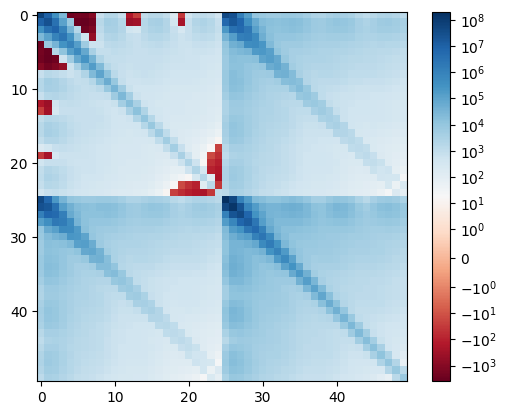

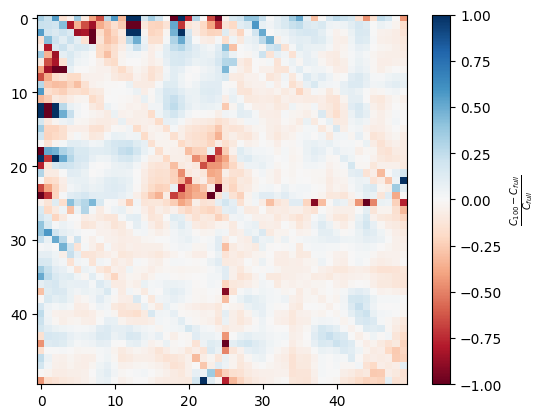

In [56]:
plt.imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
plt.colorbar()

plt.figure()
plt.imshow((C_100 - C_fid) / C_fid, cmap="RdBu", vmin=-1, vmax=1)
cbar = plt.colorbar()
cbar.set_label(r"$\frac{C_{100} - C_{full}}{C_{full}}$")
# plt.figure()
# plt.imshow((C_200 - C_fid) / C_fid, cmap="RdBu", vmin=-1, vmax=1)
# cbar = plt.colorbar()
# cbar.set_label(r"$\frac{C_{200} - C_{full}}{C_{full}}$")
# plt.figure()
# plt.imshow((C_300 - C_fid) / C_fid, cmap="RdBu", vmin=-1, vmax=1)
# cbar = plt.colorbar()
# cbar.set_label(r"$\frac{C_{300} - C_{full}}{C_{full}}$")
# plt.figure()
# plt.imshow((C_400 - C_fid) / C_fid, cmap="RdBu", vmin=-1, vmax=1)
# cbar = plt.colorbar()
# cbar.set_label(r"$\frac{C_{400} - C_{full}}{C_{full}}$")

# np.savez("/Users/JoeyA/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_100.npz", C=C_100)
# np.savez("/Users/JoeyA/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_200.npz", C=C_200)
# np.savez("/Users/JoeyA/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_300.npz", C=C_300)
# np.savez("/Users/JoeyA/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_400.npz", C=C_400)